In [2]:
import pandas as pd
import numpy as np

# Import Geocoder to get each area's coordinates
!pip install geocoder          #Uncomment this if geocoder is not installed on your system
import geocoder # import geocoder

# Import k-means for clustering stage
from sklearn.cluster import KMeans
# MinMaxScaler for normalization : to find the best K for K-Means
from sklearn.preprocessing import MinMaxScaler

# Import Folium to draw maps
!pip install folium              #Uncomment this if folium is not installed on your system
import folium

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# Import Requests for querying FoursquareAPI
import requests
print('library imported')

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
     |████████████████████████████████| 98 kB 8.6 MB/s  eta 0:00:01
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
     |██████████████████████████

In [3]:
# Demographic data of Toronto's areas
CONST_demographicDataLink = "https://www.toronto.ca/ext/open_data/catalog/data_set_files/2016_neighbourhood_profiles.csv"

In [4]:
CLIENT_ID = 'xxx' # your Foursquare ID
CLIENT_SECRET = 'xxx' # your Foursquare Secret

VERSION = '20180605' # Foursquare API version

# Size of the radius to retrieve venues from FoursquareAPI, and limit of venues per neighbourhood
CONST_venuesRadiusScan = 1000
CONST_venuesLimit = 1000

In [5]:
df_raw = pd.read_csv(CONST_demographicDataLink, encoding = "cp1252", thousands=',')

In [6]:
# Get only data about areas information : filter on Characteristic
df_cityAreas = df_raw[df_raw.Characteristic == "Neighbourhood Number"]

# Drop the useless columns, only keep CDN x City_Area
df_cityAreas = df_cityAreas.drop(df_cityAreas.columns[[0,1,2,3,4]], axis=1)

# Format the dataframe
df_cityAreas = df_cityAreas.transpose()
df_cityAreas = df_cityAreas.reset_index()
df_cityAreas = df_cityAreas.iloc[:, ::-1]
df_cityAreas.columns = ['CDN', 'City_Area']
df_cityAreas.head()

,CDN,City_Area
0,129,Agincourt North
1,128,Agincourt South-Malvern West
2,20,Alderwood
3,95,Annex
4,42,Banbury-Don Mills


In [7]:
# This function will count the leading space so we will know the data structure tree
def countLeadingSpaces(str):
    return len(str) - len(str.lstrip())

In [8]:
df_demographic = df_raw.apply(lambda x: x.str.replace(',',''))

# Filter on Topic = 'Ethnic origin population' to retrieve data about ethnic origins only
df_demographic = df_demographic[df_demographic.Topic == 'Ethnic origin population']

# Calculate the depth of Ethnic origin
df_demographic['Depth'] = df_demographic['Characteristic']

for index, row in df_demographic.iterrows():
    # The depth of Ethnic origin is calculated using the leading spaces in the data
    row['Depth'] = countLeadingSpaces(row['Depth'])

# Find each depth level of Ethnic origin, so we will be able to only keep the deepest levels
df_demographic['newLevel'] = np.where((df_demographic['Depth'].shift(+1) > df_demographic['Depth']),"new","")
    
# Reverse the dataframe
df_demographic = df_demographic.iloc[::-1]

In [9]:
# Keep value will tell us if we need to keep the row (deepest level) or if we need to drop it
df_demographic['Keep'] = 0
tmpDepth = ""

# Loop through each row
for index, row in df_demographic.iterrows():
    # We keep the first element, because the dataframe has been reversed so the first row is a deepest level
    if tmpDepth == "":
        df_demographic.loc[index, 'Keep'] = 1
        
        # We keep the current level of depth in a temp variable, so we will be able to compare it in the next row iterration
        tmpDepth = row['Depth']
    
    else:
        # If the depth level of the previous row equals the depth level of the current row : same depth, so we keep the row
        if tmpDepth == row['Depth']:
            df_demographic.loc[index, 'Keep'] = 1
        
        # New level : we reset the temp variable
        elif row['newLevel'] == "new":
            # Reset tmpDepth
            tmpDepth = ""
            
# Reverse the dataframe
df_demographic = df_demographic.iloc[::-1]

# Keep only the necessary rows
df_demographic = df_demographic[df_demographic.Keep == 1]

# Drop the useless columns
df_demographic = df_demographic.drop(['Depth', 'newLevel', 'Keep'], 1)
df_demographic.head()

,Category,Topic,Data Source,Characteristic,City of Toronto,Agincourt North,Agincourt South-Malvern West,Alderwood,Annex,Banbury-Don Mills,...,Willowdale West,Willowridge-Martingrove-Richview,Woburn,Woodbine Corridor,Woodbine-Lumsden,Wychwood,Yonge-Eglinton,Yonge-St.Clair,York University Heights,Yorkdale-Glen Park
1348,Ethnic origin,Ethnic origin population,Census Profile 98-316-X2016001,First Nations (North American Indian),27610,25,90,200,345,175,...,60,110,470,355,235,275,90,130,200,85
1349,Ethnic origin,Ethnic origin population,Census Profile 98-316-X2016001,Inuit,515,0,0,15,20,10,...,0,0,25,0,0,10,0,0,0,0
1350,Ethnic origin,Ethnic origin population,Census Profile 98-316-X2016001,Métis,8465,10,25,100,115,60,...,40,35,110,80,60,80,45,75,40,10
1352,Ethnic origin,Ethnic origin population,Census Profile 98-316-X2016001,Acadian,2315,20,0,10,60,0,...,0,0,10,45,20,30,10,0,10,0
1353,Ethnic origin,Ethnic origin population,Census Profile 98-316-X2016001,American,27470,40,70,100,705,325,...,155,145,140,275,95,275,320,280,175,100


In [10]:
# Drop the useless columns
df_demographic.drop(df_demographic.columns[[0, 1, 2, 4]], axis=1, inplace=True)
df_demographic.rename(columns={'Characteristic':''}, inplace=True)

# Put the city areas names as the dataframe columns
df_demographic = df_demographic.transpose()
df_demographic.columns = df_demographic.iloc[0]
df_demographic = df_demographic.iloc[1:]

# Drop the Total column as we won't use it
df_demographic.drop(df_demographic.columns[[0]], axis=1, inplace=True)

# Format the dataframe
df_demographic = df_demographic.reset_index()
df_demographic.rename(columns={'index':'City_Area'}, inplace=True)
df_demographic.head()


,City_Area,Inuit,Métis,Acadian,American,Canadian,New Brunswicker,Newfoundlander,Nova Scotian,Ontarian,...,Tibetan,Vietnamese,East and Southeast Asian origins; n.i.e.,Other Asian origins; n.i.e.,Fijian,Hawaiian,Maori,Polynesian; n.o.s.,Samoan,Pacific Islands origins; n.i.e.
0,Agincourt North,0,10,20,40,1295,0,10,0,0,...,0,320,20,135,0,0,0,0,0,0
1,Agincourt South-Malvern West,0,25,0,70,1125,0,0,0,0,...,0,180,10,55,0,0,0,0,0,0
2,Alderwood,15,100,10,100,2245,0,15,0,0,...,110,45,0,0,0,0,0,0,0,0
3,Annex,20,115,60,705,4655,0,10,10,0,...,0,145,15,25,0,0,10,0,0,10
4,Banbury-Don Mills,10,60,0,325,3035,0,0,10,0,...,0,115,0,45,0,0,10,0,0,0


# Part 2

# Add the latitude and the longitude coordinates of each city area

In [11]:
# This function returns the latitude and longitude of the given postal code, in Toronto
def getCoordsByCityArea(area):
    # initialize to None : this variable will allow us to loop until geocoder responds with the coordinates
    lat_lng_coords = None

    # loop until we get the coordinates
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, Toronto, Ontario'.format(area))
        lat_lng_coords = g.latlng

    latitude = lat_lng_coords[0]
    longitude = lat_lng_coords[1]
    
    return latitude, longitude

In [12]:
areasWithCoordsList = []

# Loop through each postal code from our dataframe
for area in df_cityAreas['City_Area']:
    # Fill the temp list with the coordinates from geocoder
    latitude, longitude = getCoordsByCityArea(area)
    areasWithCoordsList.append([area, latitude, longitude])
    
# Transform the temp list into a dataframe
df_coords = pd.DataFrame(areasWithCoordsList)
df_coords.columns = ['City_Area', 'Latitude', 'Longitude']

# Merge the coordinates dataframe with the original neighbourhoods dataframe (key : postal code)
df_cityAreas = pd.merge(df_cityAreas, df_coords, on='City_Area')

In [13]:
df_cityAreas.head()

,CDN,City_Area,Latitude,Longitude
0,129,Agincourt North,43.80930,-79.26707
1,128,Agincourt South-Malvern West,43.78736,-79.26935
2,20,Alderwood,43.60496,-79.54116
3,95,Annex,43.66936,-79.40280
4,42,Banbury-Don Mills,43.74041,-79.34852


# Part 3 - Neighbourhoods clustering using ethnic origins

In [14]:
address = 'Toronto, ON'

# initialize to None
lat_lng_coords = None

# loop until we get the coordinates
while(lat_lng_coords is None):
    g = geocoder.arcgis('Toronto, Ontario')
    lat_lng_coords = g.latlng

latitude_toronto = lat_lng_coords[0]
longitude_toronto = lat_lng_coords[1]

print('The geographical coordinate of Toronto are {}, {}.'.format(latitude_toronto, longitude_toronto))

The geographical coordinate of Toronto are 43.648690000000045, -79.38543999999996.


In [15]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude_toronto, longitude_toronto], zoom_start=11)

# add markers to map
for lat, lng, CDN, City_Area in zip(df_cityAreas['Latitude'], df_cityAreas['Longitude'], df_cityAreas['CDN'], df_cityAreas['City_Area']):
    label = '{} - {}'.format(CDN, City_Area)
    label = folium.Popup(label, parse_html=True)

    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_toronto) 
    
map_toronto

In [16]:
num_top = 10

# Iterate through all the dataframe
for index, row in df_demographic.iterrows():
    tempArea = row['City_Area']
    
    print("----"+tempArea+"----")
    
    # Create a temp df filtered on the current neighbourhood (key : City_Area)
    temp = df_demographic[
        (df_demographic.City_Area == tempArea)
    ].T.reset_index()
    
    temp.columns = ['Origin','Count']

    # We skip the key PostalCode x Borough x Neighbourhood : length = 3, iloc[3:]
    temp = temp.iloc[1:]
    temp['Count'] = temp['Count'].astype(float)
    
    # Round the frequency with two digits
    temp = temp.round({'Count': 2})
    
    print(temp.sort_values('Count', ascending=False).reset_index(drop=True).head(num_top))
    print('\n')

----Agincourt North----
              Origin    Count
0            Chinese  16950.0
1         Sri Lankan   2230.0
2        East Indian   2090.0
3           Filipino   1465.0
4           Canadian   1295.0
5            English    870.0
6              Tamil    855.0
7           Jamaican    780.0
8           Scottish    600.0
9              Irish    425.0


----Agincourt South-Malvern West----
              Origin    Count
0            Chinese  11455.0
1        East Indian   2180.0
2           Filipino   1405.0
3         Sri Lankan   1145.0
4           Canadian   1125.0
5            English    985.0
6           Scottish    725.0
7           Jamaican    645.0
8            Italian    630.0
9              Irish    620.0


----Alderwood----
             Origin   Count
0           English  2320.0
1          Canadian  2245.0
2             Irish  1900.0
3          Scottish  1720.0
4           Italian  1275.0
5            Polish  1225.0
6            German   940.0
7            French   850.0
8    

              Origin   Count
0           Filipino  3660.0
1        East Indian  3355.0
2            Chinese  3115.0
3           Canadian  2505.0
4         Sri Lankan  2305.0
5            English  1365.0
6           Jamaican   965.0
7           Scottish   960.0
8              Tamil   910.0
9              Irish   880.0


----Dovercourt-Wallace Emerson-Junction----
              Origin   Count
0         Portuguese  7360.0
1            English  5510.0
2           Canadian  4600.0
3              Irish  4560.0
4           Scottish  4295.0
5            Chinese  3315.0
6            Italian  3155.0
7             German  2275.0
8             French  2205.0
9        East Indian  1485.0


----Downsview-Roding-CFB----
              Origin   Count
0            Italian  8205.0
1           Filipino  4790.0
2           Canadian  2515.0
3           Jamaican  2350.0
4         Vietnamese  1950.0
5         Portuguese  1820.0
6            Chinese  1650.0
7            English  1535.0
8            Spanish  14

                                Origin   Count
0                              English  2720.0
1                                Irish  2115.0
2                             Canadian  1990.0
3                             Scottish  1955.0
4                              Italian  1075.0
5                               German   965.0
6                               French   865.0
7                               Polish   715.0
8                            Ukrainian   650.0
9        British Isles origins; n.i.e.   415.0


----Lambton Baby Point----
             Origin   Count
0           English  1840.0
1          Scottish  1610.0
2             Irish  1505.0
3          Canadian  1250.0
4            German   760.0
5            Polish   735.0
6         Ukrainian   730.0
7           Italian   615.0
8            French   595.0
9        Portuguese   350.0


----L'Amoreaux----
              Origin    Count
0            Chinese  16745.0
1        East Indian   3395.0
2           Canadian   2695.0
3    

              Origin   Count
0            Italian  2855.0
1           Canadian  1085.0
2         Portuguese   925.0
3         Vietnamese   785.0
4            English   745.0
5           Jamaican   560.0
6           Scottish   525.0
7           Filipino   520.0
8            Chinese   445.0
9        East Indian   410.0


----Playter Estates-Danforth----
           Origin   Count
0         English  2320.0
1        Scottish  1970.0
2           Irish  1780.0
3        Canadian  1425.0
4          German   915.0
5          French   765.0
6           Greek   735.0
7         Chinese   550.0
8          Polish   380.0
9         Italian   370.0


----Pleasant View----
              Origin   Count
0            Chinese  5795.0
1              Greek  1265.0
2            Italian  1220.0
3           Canadian  1040.0
4        East Indian   905.0
5            English   800.0
6           Scottish   745.0
7           Filipino   685.0
8              Irish   595.0
9            Iranian   470.0


----Princess-Ro

             Origin   Count
0        Portuguese  3380.0
1          Canadian  1190.0
2           Italian  1125.0
3           English  1080.0
4             Irish   815.0
5          Scottish   775.0
6        Vietnamese   565.0
7           Chinese   430.0
8            French   415.0
9          Jamaican   380.0


----Wexford/Maryvale----
              Origin   Count
0           Canadian  3710.0
1           Filipino  3535.0
2            English  2695.0
3              Greek  2325.0
4            Chinese  2310.0
5              Irish  2010.0
6        East Indian  1935.0
7           Scottish  1915.0
8            Italian  1285.0
9         Sri Lankan  1065.0


----Willowdale East----
              Origin    Count
0            Chinese  17240.0
1            Iranian   6805.0
2             Korean   5395.0
3        East Indian   2640.0
4            English   2575.0
5           Canadian   2325.0
6           Scottish   1900.0
7              Irish   1850.0
8            Russian   1630.0
9            Italian

In [17]:
def return_most_common_ethn(row, num_top):
    # Remove the key from the row
    row_categories = row.iloc[1:].astype(float)
    
    # Sort ascending
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    # Return the top num_top_venues
    return row_categories_sorted.index.values[0:num_top]

In [18]:
num_top = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['City_Area']

for ind in np.arange(num_top):
    try:
        columns.append('{}{} Most Common Origin'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Origin'.format(ind+1))

# create a new dataframe, and set it with the columns names
areas_ethn_sorted = pd.DataFrame(columns=columns)

# add the keys from the grouped dataframe (City_Area)
areas_ethn_sorted['City_Area'] = df_demographic['City_Area']

# loop through each rows
for ind in np.arange(df_demographic.shape[0]):
    areas_ethn_sorted.iloc[ind, 1:] = return_most_common_ethn(df_demographic.iloc[ind, :], num_top)

areas_ethn_sorted.head()

,City_Area,1st Most Common Origin,2nd Most Common Origin,3rd Most Common Origin,4th Most Common Origin,5th Most Common Origin,6th Most Common Origin,7th Most Common Origin,8th Most Common Origin,9th Most Common Origin,10th Most Common Origin
0,Agincourt North,Chinese,Sri Lankan,East Indian,Filipino,Canadian,English,Tamil,Jamaican,Scottish,Irish
1,Agincourt South-Malvern West,Chinese,East Indian,Filipino,Sri Lankan,Canadian,English,Scottish,Jamaican,Italian,Irish
2,Alderwood,English,Canadian,Irish,Scottish,Italian,Polish,German,French,Ukrainian,Portuguese
3,Annex,English,Irish,Scottish,Canadian,German,French,Polish,Chinese,Italian,Russian
4,Banbury-Don Mills,Chinese,English,Irish,Canadian,Scottish,East Indian,German,Filipino,Polish,French


In [19]:
toronto_areas_clustering = df_demographic.drop('City_Area', 1)

data = toronto_areas_clustering.astype(float)

data.head()

,Inuit,Métis,Acadian,American,Canadian,New Brunswicker,Newfoundlander,Nova Scotian,Ontarian,Québécois,...,Tibetan,Vietnamese,East and Southeast Asian origins; n.i.e.,Other Asian origins; n.i.e.,Fijian,Hawaiian,Maori,Polynesian; n.o.s.,Samoan,Pacific Islands origins; n.i.e.
0,0.0,10.0,20.0,40.0,1295.0,0.0,10.0,0.0,0.0,0.0,...,0.0,320.0,20.0,135.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,25.0,0.0,70.0,1125.0,0.0,0.0,0.0,0.0,0.0,...,0.0,180.0,10.0,55.0,0.0,0.0,0.0,0.0,0.0,0.0
2,15.0,100.0,10.0,100.0,2245.0,0.0,15.0,0.0,0.0,20.0,...,110.0,45.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,20.0,115.0,60.0,705.0,4655.0,0.0,10.0,10.0,0.0,15.0,...,0.0,145.0,15.0,25.0,0.0,0.0,10.0,0.0,0.0,10.0
4,10.0,60.0,0.0,325.0,3035.0,0.0,0.0,10.0,0.0,15.0,...,0.0,115.0,0.0,45.0,0.0,0.0,10.0,0.0,0.0,0.0


In [20]:
mms = MinMaxScaler()
mms.fit(data)
data_transformed = mms.transform(data)

pd.DataFrame(data_transformed).head()

,0,1,2,3,4,5,6,7,8,9,...,241,242,243,244,245,246,247,248,249,250
0,0.000000,0.032787,0.235294,0.048193,0.088448,0.0,0.153846,0.0,0.0,0.0,...,0.000000,0.089261,0.266667,0.482143,0.0,0.0,0.0,0.0,0.0,0.000000
1,0.000000,0.081967,0.000000,0.084337,0.067990,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.050209,0.133333,0.196429,0.0,0.0,0.0,0.0,0.0,0.000000
2,0.500000,0.327869,0.117647,0.120482,0.202768,0.0,0.230769,0.0,0.0,0.4,...,0.057292,0.012552,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
3,0.666667,0.377049,0.705882,0.849398,0.492780,0.0,0.153846,0.5,0.0,0.3,...,0.000000,0.040446,0.200000,0.089286,0.0,0.0,0.4,0.0,0.0,0.333333
4,0.333333,0.196721,0.000000,0.391566,0.297834,0.0,0.000000,0.5,0.0,0.3,...,0.000000,0.032078,0.000000,0.160714,0.0,0.0,0.4,0.0,0.0,0.000000


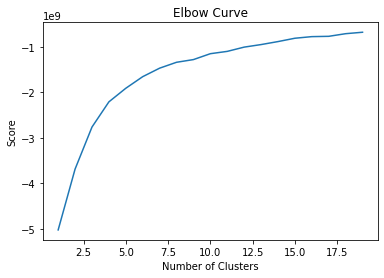

In [21]:
Nc = range(1, 20)
kmeans = [KMeans(n_clusters=i) for i in Nc]
kmeans
score = [kmeans[i].fit(data).score(data) for i in range(len(kmeans))]
score
plt.plot(Nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [22]:
# set number of clusters
kclusters = 5

toronto_areas_clustering = df_demographic.drop('City_Area', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(data)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([2, 2, 0, 1, 4, 0, 4, 4, 4, 1], dtype=int32)

In [23]:
# add clustering labels
areas_ethn_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [24]:
toronto_merged = df_cityAreas

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(areas_ethn_sorted.set_index(['City_Area']), on=['City_Area'])

toronto_merged.head() # check the last columns!

,CDN,City_Area,Latitude,Longitude,Cluster Labels,1st Most Common Origin,2nd Most Common Origin,3rd Most Common Origin,4th Most Common Origin,5th Most Common Origin,6th Most Common Origin,7th Most Common Origin,8th Most Common Origin,9th Most Common Origin,10th Most Common Origin
0,129,Agincourt North,43.80930,-79.26707,2,Chinese,Sri Lankan,East Indian,Filipino,Canadian,English,Tamil,Jamaican,Scottish,Irish
1,128,Agincourt South-Malvern West,43.78736,-79.26935,2,Chinese,East Indian,Filipino,Sri Lankan,Canadian,English,Scottish,Jamaican,Italian,Irish
2,20,Alderwood,43.60496,-79.54116,0,English,Canadian,Irish,Scottish,Italian,Polish,German,French,Ukrainian,Portuguese
3,95,Annex,43.66936,-79.40280,1,English,Irish,Scottish,Canadian,German,French,Polish,Chinese,Italian,Russian
4,42,Banbury-Don Mills,43.74041,-79.34852,4,Chinese,English,Irish,Canadian,Scottish,East Indian,German,Filipino,Polish,French


In [25]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, cityArea, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['City_Area'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(cityArea) + ' - Cluster ' + str(cluster), parse_html=True)
    cluster = int(cluster)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [26]:
toronto_merged[toronto_merged['Cluster Labels'] == 0].head(50)

,CDN,City_Area,Latitude,Longitude,Cluster Labels,1st Most Common Origin,2nd Most Common Origin,3rd Most Common Origin,4th Most Common Origin,5th Most Common Origin,6th Most Common Origin,7th Most Common Origin,8th Most Common Origin,9th Most Common Origin,10th Most Common Origin
2,20,Alderwood,43.60496,-79.541160,0,English,Canadian,Irish,Scottish,Italian,Polish,German,French,Ukrainian,Portuguese
5,34,Bathurst Manor,43.76378,-79.454770,0,Filipino,Russian,Italian,Polish,Canadian,Jewish,Chinese,English,Ukrainian,Greek
10,112,Beechborough-Greenbrook,43.69311,-79.478310,0,Portuguese,Jamaican,Italian,Canadian,Filipino,East Indian,English,Spanish,Vietnamese,Other African origins; n.i.e.
13,24,Black Creek,43.76636,-79.521500,0,Vietnamese,Jamaican,Canadian,Italian,East Indian,Chinese,Filipino,Iraqi,Ghanaian,Other African origins; n.i.e.
14,69,Blake-Jones,43.67522,-79.337620,0,English,Canadian,Irish,Scottish,Chinese,French,German,Greek,East Indian,Jamaican
15,108,Briar Hill-Belgravia,43.69852,-79.451250,0,Filipino,Italian,Portuguese,Canadian,English,Scottish,Irish,Albanian,Russian,Polish
16,41,Bridle Path-Sunnybrook-York Mills,43.72732,-79.380870,0,English,Scottish,Canadian,Chinese,Irish,Italian,German,French,Russian,Polish
17,57,Broadview North,43.68937,-79.354290,0,English,Irish,Scottish,Greek,Canadian,French,German,Chinese,Filipino,Serbian
18,30,Brookhaven-Amesbury,43.70031,-79.484650,0,Italian,Portuguese,Jamaican,Canadian,Filipino,Vietnamese,Chinese,Other African origins; n.i.e.,English,East Indian
19,71,Cabbagetown-South St. James Town,43.66760,-79.364190,0,English,Irish,Scottish,Canadian,German,French,Chinese,Italian,British Isles origins; n.i.e.,Polish


In [28]:
toronto_merged[toronto_merged['Cluster Labels'] == 1].head(50)


,CDN,City_Area,Latitude,Longitude,Cluster Labels,1st Most Common Origin,2nd Most Common Origin,3rd Most Common Origin,4th Most Common Origin,5th Most Common Origin,6th Most Common Origin,7th Most Common Origin,8th Most Common Origin,9th Most Common Origin,10th Most Common Origin
3,95,Annex,43.66936,-79.40280,1,English,Irish,Scottish,Canadian,German,French,Polish,Chinese,Italian,Russian
9,39,Bedford Park-Nortown,43.73066,-79.42450,1,Canadian,Polish,English,Russian,Scottish,Irish,Filipino,Jewish,German,Italian
12,122,Birchcliffe-Cliffside,43.69472,-79.26460,1,English,Irish,Canadian,Scottish,French,German,Chinese,Italian,Filipino,British Isles origins; n.i.e.
23,75,Church-Yonge Corridor,43.66024,-79.37868,1,English,Irish,Scottish,Chinese,Canadian,French,German,East Indian,Italian,Polish
32,93,Dovercourt-Wallace Emerson-Junction,43.66604,-79.43687,1,Portuguese,English,Canadian,Irish,Scottish,Chinese,Italian,German,French,East Indian
35,62,East End-Danforth,43.68420,-79.29887,1,English,Irish,Scottish,Canadian,French,German,Chinese,Italian,Polish,British Isles origins; n.i.e.
49,88,High Park North,43.65769,-79.46449,1,English,Irish,Scottish,Canadian,German,Polish,French,Ukrainian,Italian,Russian
50,87,High Park-Swansea,43.64704,-79.47114,1,English,Irish,Scottish,Canadian,German,Polish,French,Italian,Ukrainian,British Isles origins; n.i.e.
58,14,Islington-City Centre West,43.63608,-79.54296,1,English,Canadian,Italian,Irish,Scottish,Polish,Ukrainian,East Indian,German,Chinese
68,105,Lawrence Park North,43.72830,-79.40642,1,English,Scottish,Canadian,Irish,German,Chinese,French,Polish,Italian,Russian


In [29]:
toronto_merged[toronto_merged['Cluster Labels'] == 2].head(10)

,CDN,City_Area,Latitude,Longitude,Cluster Labels,1st Most Common Origin,2nd Most Common Origin,3rd Most Common Origin,4th Most Common Origin,5th Most Common Origin,6th Most Common Origin,7th Most Common Origin,8th Most Common Origin,9th Most Common Origin,10th Most Common Origin
0,129,Agincourt North,43.80930,-79.26707,2,Chinese,Sri Lankan,East Indian,Filipino,Canadian,English,Tamil,Jamaican,Scottish,Irish
1,128,Agincourt South-Malvern West,43.78736,-79.26935,2,Chinese,East Indian,Filipino,Sri Lankan,Canadian,English,Scottish,Jamaican,Italian,Irish
66,117,L'Amoreaux,43.79730,-79.31222,2,Chinese,East Indian,Canadian,Sri Lankan,Filipino,English,Armenian,Jamaican,Scottish,Irish
76,130,Milliken,43.82325,-79.27729,2,Chinese,Sri Lankan,East Indian,Filipino,Canadian,Tamil,Jamaican,English,Vietnamese,Spanish
112,116,Steeles,43.81231,-79.32154,2,Chinese,East Indian,Canadian,Filipino,English,Greek,Italian,Scottish,Sri Lankan,Egyptian
129,51,Willowdale East,43.77249,-79.40041,2,Chinese,Iranian,Korean,East Indian,English,Canadian,Scottish,Irish,Russian,Italian


In [30]:
toronto_merged[toronto_merged['Cluster Labels'] == 3].head(10)

,CDN,City_Area,Latitude,Longitude,Cluster Labels,1st Most Common Origin,2nd Most Common Origin,3rd Most Common Origin,4th Most Common Origin,5th Most Common Origin,6th Most Common Origin,7th Most Common Origin,8th Most Common Origin,9th Most Common Origin,10th Most Common Origin
73,132,Malvern,43.81023,-79.22038,3,East Indian,Sri Lankan,Filipino,Chinese,Jamaican,Canadian,English,Tamil,Guyanese,Pakistani
81,2,Mount Olive-Silverstone-Jamestown,43.74721,-79.58826,3,East Indian,Iraqi,Jamaican,Canadian,Somali,Italian,Assyrian,Sri Lankan,Other African origins; n.i.e.,Ghanaian
105,131,Rouge,43.80766,-79.17405,3,East Indian,Sri Lankan,Canadian,Filipino,Jamaican,English,Chinese,Tamil,Scottish,Irish
124,1,West Humber-Clairville,43.71456,-79.59261,3,East Indian,Jamaican,Canadian,Filipino,Italian,Punjabi,English,Guyanese,Chinese,Scottish
132,137,Woburn,43.76748,-79.22829,3,East Indian,Canadian,Sri Lankan,Chinese,Filipino,English,Irish,Scottish,Jamaican,Tamil


In [31]:
toronto_merged[toronto_merged['Cluster Labels'] == 4].head(50)

,CDN,City_Area,Latitude,Longitude,Cluster Labels,1st Most Common Origin,2nd Most Common Origin,3rd Most Common Origin,4th Most Common Origin,5th Most Common Origin,6th Most Common Origin,7th Most Common Origin,8th Most Common Origin,9th Most Common Origin,10th Most Common Origin
4,42,Banbury-Don Mills,43.74041,-79.34852,4,Chinese,English,Irish,Canadian,Scottish,East Indian,German,Filipino,Polish,French
6,76,Bay Street Corridor,43.65771,-79.38618,4,Chinese,English,Canadian,Scottish,Irish,East Indian,Korean,German,French,Italian
7,52,Bayview Village,43.77710,-79.37957,4,Chinese,Iranian,Korean,English,Canadian,Irish,Scottish,East Indian,Filipino,Polish
8,49,Bayview Woods-Steeles,43.79485,-79.38222,4,Chinese,Iranian,English,Canadian,Korean,Polish,Irish,Scottish,Russian,East Indian
11,127,Bendale,43.75963,-79.25739,4,Chinese,East Indian,Filipino,Canadian,English,Scottish,Irish,Sri Lankan,Greek,French
30,47,Don Valley Village,43.78558,-79.34986,4,Chinese,Filipino,East Indian,Iranian,English,Canadian,Irish,Scottish,Korean,Armenian
31,126,Dorset Park,43.75533,-79.27746,4,Filipino,East Indian,Chinese,Canadian,Sri Lankan,English,Jamaican,Scottish,Tamil,Irish
48,53,Henry Farm,43.77229,-79.34086,4,Chinese,East Indian,Filipino,Iranian,Canadian,English,Scottish,Irish,Afghan,Korean
52,48,Hillcrest Village,43.80303,-79.35346,4,Chinese,East Indian,Canadian,Iranian,Korean,English,Russian,Scottish,Polish,Irish
62,78,Kensington-Chinatown,43.65331,-79.39634,4,Chinese,Canadian,English,Irish,Scottish,French,German,Italian,Polish,East Indian


# Part 4 - Use cases

This function will retrieve the FoursquareAPI venues for all the neighbourhoods given in parameters

In [85]:
def getNearbyVenues(cdn, latitudes, longitudes):
    
    venues_list=[]
    # Loop through each neighbourhood given in parameters
    for cdn, lat, lng in zip(cdn, latitudes, longitudes):

        # create the API request URL to explore the neighbourhood using FoursquareAPI
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            CONST_venuesRadiusScan, 
            CONST_venuesLimit)

        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue : name, latitude, longitude, and the categories' names
        venues_list.append([(
            cdn,
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    # add the venues in the dataframe
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = [
                        'CDN',
                        'Area Latitude', 
                        'Area Longitude', 
                        'Venue', 
                        'Venue Latitude', 
                        'Venue Longitude', 
                        'Venue Category'
    ]
    
    return(nearby_venues)

In [87]:
toronto_chinese = toronto_merged[(toronto_merged['Cluster Labels'] == 3) | (toronto_merged['Cluster Labels'] == 1)]

toronto_chinese.head()

,CDN,City_Area,Latitude,Longitude,Cluster Labels,1st Most Common Origin,2nd Most Common Origin,3rd Most Common Origin,4th Most Common Origin,5th Most Common Origin,6th Most Common Origin,7th Most Common Origin,8th Most Common Origin,9th Most Common Origin,10th Most Common Origin
3,95,Annex,43.66936,-79.40280,1,English,Irish,Scottish,Canadian,German,French,Polish,Chinese,Italian,Russian
9,39,Bedford Park-Nortown,43.73066,-79.42450,1,Canadian,Polish,English,Russian,Scottish,Irish,Filipino,Jewish,German,Italian
12,122,Birchcliffe-Cliffside,43.69472,-79.26460,1,English,Irish,Canadian,Scottish,French,German,Chinese,Italian,Filipino,British Isles origins; n.i.e.
23,75,Church-Yonge Corridor,43.66024,-79.37868,1,English,Irish,Scottish,Chinese,Canadian,French,German,East Indian,Italian,Polish
32,93,Dovercourt-Wallace Emerson-Junction,43.66604,-79.43687,1,Portuguese,English,Canadian,Irish,Scottish,Chinese,Italian,German,French,East Indian


In [89]:

toronto_irish = toronto_merged[(toronto_merged['Cluster Labels'] == 4)]

toronto_irish.head()

,CDN,City_Area,Latitude,Longitude,Cluster Labels,1st Most Common Origin,2nd Most Common Origin,3rd Most Common Origin,4th Most Common Origin,5th Most Common Origin,6th Most Common Origin,7th Most Common Origin,8th Most Common Origin,9th Most Common Origin,10th Most Common Origin
4,42,Banbury-Don Mills,43.74041,-79.34852,4,Chinese,English,Irish,Canadian,Scottish,East Indian,German,Filipino,Polish,French
6,76,Bay Street Corridor,43.65771,-79.38618,4,Chinese,English,Canadian,Scottish,Irish,East Indian,Korean,German,French,Italian
7,52,Bayview Village,43.77710,-79.37957,4,Chinese,Iranian,Korean,English,Canadian,Irish,Scottish,East Indian,Filipino,Polish
8,49,Bayview Woods-Steeles,43.79485,-79.38222,4,Chinese,Iranian,English,Canadian,Korean,Polish,Irish,Scottish,Russian,East Indian
11,127,Bendale,43.75963,-79.25739,4,Chinese,East Indian,Filipino,Canadian,English,Scottish,Irish,Sri Lankan,Greek,French
